# Exploratory Points: Sentiment Analysis of Shakespeare’s Plays

# Rob Johnston and Haris Memic


In this part we executed sentiment analysis of Shakespeare. <br /><br />
We made use of the AFINN library (https://github.com/fnielsen/afinn) which implements a dictionary-based approach to sentiment analysis - based on "AFINN Lexicon". The AFINN lexicon contains a list of words with corresponding valence values. Words-sentiments are scored from -5 to 5 (e.g. “outstanding” = +5;  catastrophic = -4).
<br />
Some of the algorithms for which <b>we entirely wrote our own code</b> are based on the senetiment anaylsis concepts presented in the paper "Nalisnick, Eric T., and Henry S. Baird. "Extracting Sentiment Networks from Shakespeare's Plays." 2013 12th International Conference on Document Analysis and Recognition. IEEE, 2013."<br />
Other algorithms like those for longitudinal sentiment analysis of individual plays trough time we developed entirely on our own.<br />

We start by importing neccessary libraries.<br />

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ColorConverter

import numpy as np
import pandas as pd
import nltk
import string
from collections import OrderedDict

# Using AFINN library - pip install afinn
from afinn import Afinn

# Load the NLTK punkt tokenizer - uncomment the next line if you don't have the punkt tokenizer 
# installed - it will open a dialog that will allow you to do so.
#nltk.download()


We here include plotting related functions:

In [22]:
# special matplotlib command for global plot configuration
from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.colors import ListedColormap

dark2_colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d','#666666']
set2_colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494','#b3b3b3']

bold_colors = ['#FF0000', '#00FF00', '#FFAAAA', '#0000FF']
light_colors = ['#FFAAAA', '#AAFFAA', '#AAAAFF', '#00FF00']
cmap_light = ListedColormap(light_colors)
cmap_bold = ListedColormap(bold_colors)
dark2_cmap = ListedColormap(dark2_colors)
set2_cmap = ListedColormap(dark2_colors)
light_grey = np.array([float(248)/float(255)]*3)
shade_black = '#262626'

def set_mpl_params():
    rcParams['figure.figsize'] = (10, 6)
    rcParams['figure.dpi'] = 150
    rcParams['axes.prop_cycle'].by_key()['color'][1]
    rcParams['lines.linewidth'] = 2
    rcParams['axes.facecolor'] = 'white'
    rcParams['font.size'] = 16
    rcParams['patch.edgecolor'] = 'white'
    rcParams['patch.facecolor'] = dark2_colors[0]
    rcParams['font.family'] = 'StixGeneral'

set_mpl_params()

# Remove border function taken from CS109 2013 
#############
def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecessary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
def cible_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Make a target axis at 0,0 with ticks along the axis lines
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()

    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('data',0))
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('data',0))

    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

<b>Reading in Shakespeare's plays and calculating sentiment scores for all of the utterances</b> (these scores are used for latter analysis) 

In [23]:
# Read in Shakespeare's plays
df = pd.read_pickle('data.pickle')

afinn = Afinn()

# For every utterance, add a Valence score
afinn_scores = [afinn.score(text) for text in df.Utterance]

df['afinn'] = afinn_scores

<b>Extracting the text of 'Hamlet':</b>

In [24]:
df_hamlet = df[df.Play=="hamlet"]

alltext = ''
for text in df_hamlet['Utterance']:
    alltext += text + ' '

<b>Removing Punctuation and Tokenizing :</b>

In [25]:
translator = str.maketrans({key: None for key in string.punctuation})
no_punctuation = alltext.translate(translator)
tokens = nltk.word_tokenize(no_punctuation)

<b>Sliding Window:</b><br />
We proceeded by defining a "sliding window". We initially set the sliding window to encompass first N=500 words of the play. We will "move" this window, word-by-word, troughout the entire play and calculate the sum of sentiment scores for the words in each of these windows. This allows us to obtain a fine-grained analysis of the sentiments.<br />
<br />
For example, the following text:<br /> 
> "Rob Haris doing Shakespeare sentiment analysis" 

with a sliding window of N=3 would give us the following sliding-window instances:<br />

> Rob Haris doing

> Haris doing Shakespeare

> doing Shakespeare sentiment

> Shakespeare sentiment analysis


<b>Creating the "sliding window" instances by "moving" the window word-by-word:</b>

In [26]:
N = 500
grams = [tokens[i:i+N] for i in range(len(tokens)-N+1)]

for i in range (len(grams)):
    grams[i] = " ".join(grams[i])
    

grams_df = pd.DataFrame(grams)
grams_df = grams_df.rename(columns = {0:'Speech'})

<b>Calculating sentiment scores for each othe sliding-window instances:</b>

In [27]:
afinn_scores = [afinn.score(text) for text in grams_df.Speech]

grams_df['afinn'] = afinn_scores

<b>Plotting the sentiment movement troughout the play:</b>

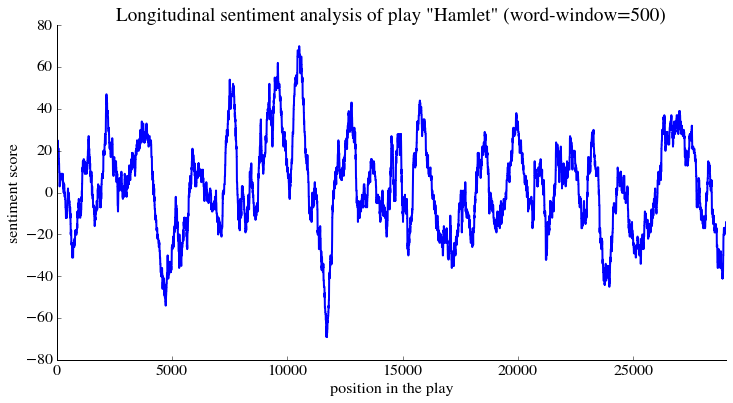

In [28]:
plt.figure(figsize=(12, 6))

grams_df['afinn'].plot()

plt.title('Longitudinal sentiment analysis of play "Hamlet" (word-window=500)')
plt.xlabel('position in the play')
plt.ylabel('sentiment score')
remove_border()
plt.show()

<b>In what follows we repeat the above analysis but this time with a sliding window of size N=100:<b/>

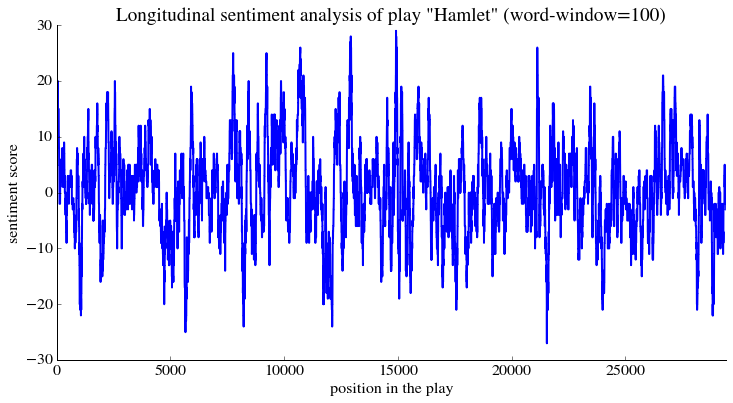

In [29]:
# Re-read in Shakespeare's plays
df = pd.read_pickle('data.pickle')

afinn = Afinn()

# For every utterance, add a Valence score
afinn_scores = [afinn.score(text) for text in df.Utterance]

df['afinn'] = afinn_scores

#############

df_hamlet = df[df.Play=="hamlet"]
df_hamlet.shape

alltext = ''
for text in df_hamlet['Utterance']:
    alltext += text + ' '

#############

translator = str.maketrans({key: None for key in string.punctuation})
no_punctuation = alltext.translate(translator)
tokens = nltk.word_tokenize(no_punctuation)

#############

N = 100
grams = [tokens[i:i+N] for i in range(len(tokens)-N+1)]

for i in range (len(grams)):
    grams[i] = " ".join(grams[i])
    

grams_df = pd.DataFrame(grams)
grams_df = grams_df.rename(columns = {0:'Speech'})

#############

afinn_scores = [afinn.score(text) for text in grams_df.Speech]

grams_df['afinn'] = afinn_scores

#############

plt.figure(figsize=(12, 6))

grams_df['afinn'].plot()

plt.title('Longitudinal sentiment analysis of play "Hamlet" (word-window=100)')
plt.xlabel('position in the play')
plt.ylabel('sentiment score')
remove_border()
plt.show()

<b>
This gave us what appears to be a too sensitive analysis. Apparently the sliding window of 100 words wasn't long enough to more sensibly analyze the stability of sentiments troughout the play. However this does appear to show how Shakespear manipulate sentiments troughout the play - thus making the play very interesting for the readers. 
In what follows we repeat the analysis one more time - with a sliding window of size N=1000:</b>

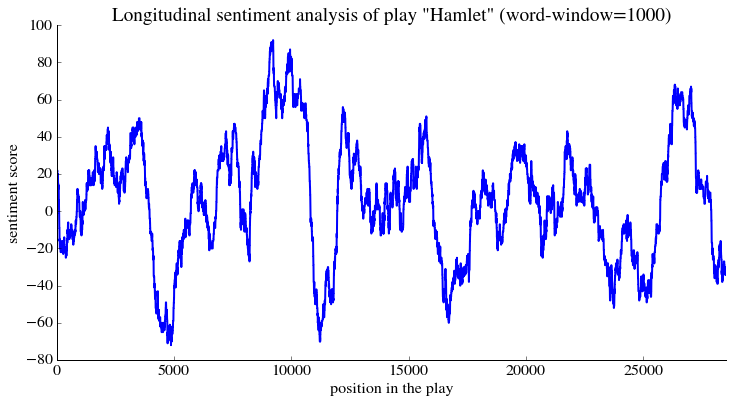

In [30]:
# Read in Shakespeare's plays
df = pd.read_pickle('data.pickle')

afinn = Afinn()

# For every utterance, add a Valence score
afinn_scores = [afinn.score(text) for text in df.Utterance]

df['afinn'] = afinn_scores

#############

df_hamlet = df[df.Play=="hamlet"]
df_hamlet.shape

alltext = ''
for text in df_hamlet['Utterance']:
    alltext += text + ' '

#############

translator = str.maketrans({key: None for key in string.punctuation})
no_punctuation = alltext.translate(translator)
tokens = nltk.word_tokenize(no_punctuation)

#############

N = 1000
grams = [tokens[i:i+N] for i in range(len(tokens)-N+1)]

for i in range (len(grams)):
    grams[i] = " ".join(grams[i])
    

grams_df = pd.DataFrame(grams)
grams_df = grams_df.rename(columns = {0:'Speech'})

#############

afinn_scores = [afinn.score(text) for text in grams_df.Speech]

grams_df['afinn'] = afinn_scores

#############

plt.figure(figsize=(12, 6))

grams_df['afinn'].plot()

plt.title('Longitudinal sentiment analysis of play "Hamlet" (word-window=1000)')
plt.xlabel('position in the play')
plt.ylabel('sentiment score')
remove_border()
plt.show()

<b>The sliding window of 1000 words provided the aditional stability of sentiment movements troughout the play. The analysis shows how Shakespeare gradually raises the positivity of the sentiment in the "Hamlet" at the beginning of the play. He then, completely drops his play into the deep deapths of the negative senetiments :). This is followed by a number the high peeks and deep slopes of the sementiments. At the end of the play Shakespeare increases the positivity of the sentiments in what seems to be a preparation for the last downward slope of the sentiments.</b>

<b>
Romeo and Juliet...the love story :)<br /><br />
We proceed to analyse the movements of the sentiments trough "Romeo and Juliet". Based on the lessons drown from experimentation of sliding window sizes in "Hamlet", we analyze "Romeo and Juliet" with the sliding window of 1000 words.
<b/>

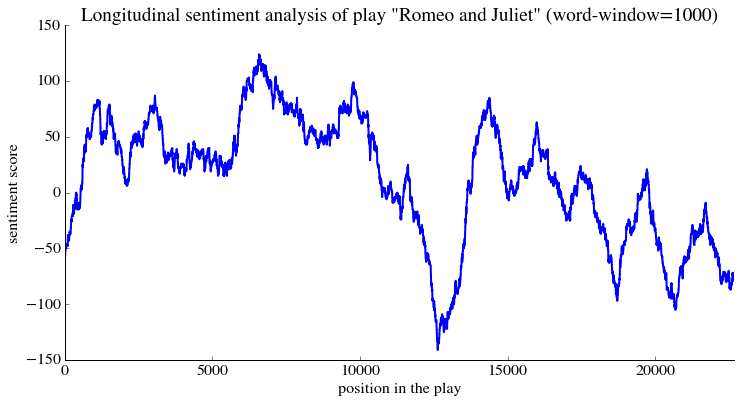

In [31]:
# Read in Shakespeare's plays
df = pd.read_pickle('data.pickle')

afinn = Afinn()

# For every utterance, add a Valence score
afinn_scores = [afinn.score(text) for text in df.Utterance]

df['afinn'] = afinn_scores

#############

df_hamlet = df[df.Play=="r_and_j"]
df_hamlet.shape

alltext = ''
for text in df_hamlet['Utterance']:
    alltext += text + ' '

#############

translator = str.maketrans({key: None for key in string.punctuation})
no_punctuation = alltext.translate(translator)
tokens = nltk.word_tokenize(no_punctuation)

#############

N = 1000
grams = [tokens[i:i+N] for i in range(len(tokens)-N+1)]

for i in range (len(grams)):
    grams[i] = " ".join(grams[i])
    

grams_df = pd.DataFrame(grams)
grams_df = grams_df.rename(columns = {0:'Speech'})

#############

afinn_scores = [afinn.score(text) for text in grams_df.Speech]

grams_df['afinn'] = afinn_scores

#############

plt.figure(figsize=(12, 6))

grams_df['afinn'].plot()

plt.title('Longitudinal sentiment analysis of play "Romeo and Juliet" (word-window=1000)')
plt.xlabel('position in the play')
plt.ylabel('sentiment score')
remove_border()
plt.show()

<b>The "Romeo and Juliet" play begins with very high positive sentiments. This positive sentiment continues almost to the half of the play and then very sharply goes into the deepest deapths of the negativity. The positivity of the sentiments of the play, however, then sharply "recoveres", after which it heads (trough the number of high and low "exchanges") into the negativity of the plays ending.</b>

<b>We now proceed by selecting a comedy, in order to try explore how Shakespear manipulates with sentiments in a comedy "environment". For this purpose we selected Shakespear's "Taming":</b>

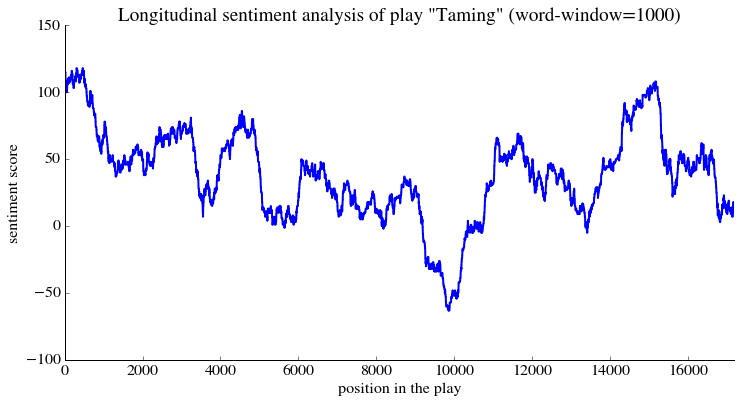

In [32]:
# Read in Shakespeare's plays
df = pd.read_pickle('data.pickle')

afinn = Afinn()

# For every utterance, add a Valence score
afinn_scores = [afinn.score(text) for text in df.Utterance]

df['afinn'] = afinn_scores

#############

df_hamlet = df[df.Play=="taming"]
df_hamlet.shape

alltext = ''
for text in df_hamlet['Utterance']:
    alltext += text + ' '

#############

translator = str.maketrans({key: None for key in string.punctuation})
no_punctuation = alltext.translate(translator)
tokens = nltk.word_tokenize(no_punctuation)

#############

N = 1000
grams = [tokens[i:i+N] for i in range(len(tokens)-N+1)]

for i in range (len(grams)):
    grams[i] = " ".join(grams[i])
    

grams_df = pd.DataFrame(grams)
grams_df = grams_df.rename(columns = {0:'Speech'})

#############

afinn_scores = [afinn.score(text) for text in grams_df.Speech]

grams_df['afinn'] = afinn_scores

#############

plt.figure(figsize=(12, 6))

grams_df['afinn'].plot()

plt.title('Longitudinal sentiment analysis of play "Taming" (word-window=1000)')
plt.xlabel('position in the play')
plt.ylabel('sentiment score')
remove_border()
plt.show()

<b>The result of this analysis clearly shows how Shakespears comedy is allmost entirely immersed in a positity of the sementimens. The play, as expected does go trough higher and lower levels of positive sentiments, at one point even dropping into the negative sentiments.</b>

## Differentiating comedies from tragedies

<b>
We proceeded with an attempt of classifying the Shakespear's plays into the comedies and tragedies, based on the average summed valence values for each of the plays.
</b>


In [33]:
awv = {}

for play in df.Play.unique():
    dfp = df[df['Play']==play]

    # Sum the valences for each of the utterances
    sum_valence = dfp.afinn.sum()
    
    # Generate one big string for the full play
    alltext = ''
    for text in dfp['Utterance']:
        alltext += text + ' '
    
    
    # The following lines can be added if you wish to take into account the play's length
    #
    
    # Create a dictionary using a comprehension - this maps every character from
    # string.punctuation to None. Initialize a translation object from it.
    #translator = str.maketrans({key: None for key in string.punctuation})

    # Remove the punctuation using the translator
    #no_punctuation = alltext.translate(translator)
    
    # Split the play into tokens
    #tokens = nltk.word_tokenize(no_punctuation)

    # Calculate the number of words in the play
    #len_play = len(tokens)
    
    
    # Find the number of words in AFINN that are in the play
    words_in_afinn = afinn.find_all(alltext)


    # Calculate the average word valence
    # The paper reffered at the beginning of this notebook seems to propose two methods to calculate it:
    # i) "Fig. 1. For each play the valence for each word was summed and then divided by the number
    # of words in both the word list (AFINN) and the respective play."
    # ii) "...  by summing the valence values for all words in the play and then dividing by the number 
    # of the play’s words in AFINN"
    #
    # We've chosen the later.
    awv[play] = (sum_valence / len(words_in_afinn)) 

    
# Define the list of tragedies and comedies in the order given in the paper
tragedies = ['titus','r_and_j', 'j_caesar', 'hamlet', 'othello', 'timon', 'lear', 'macbeth', 'a_and_c', 'coriolan']
comedies = ['all_well', 'as_you', 'com_err', 'lll', 'm_for_m', 'merchant', 'm_wives', 'dream', 'much_ado', 'pericles',
           'taming', 't_night', 'two_gent', 'win_tale']
all_labels = comedies + tragedies 

awv_sorted = OrderedDict()
for name in comedies:
    awv_sorted[name] = awv[name]
    
for name in tragedies:
    awv_sorted[name] = awv[name]

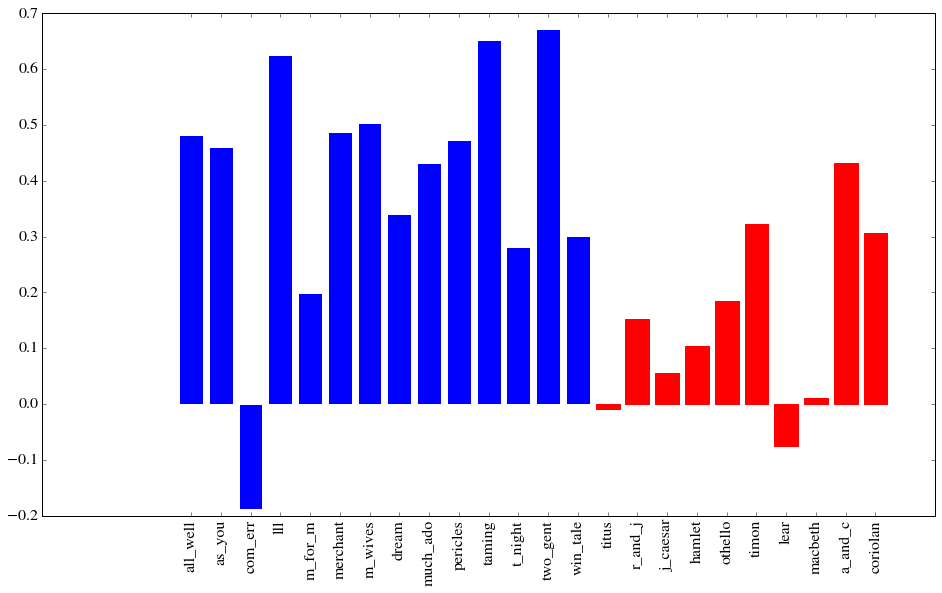

In [34]:
plt.rcParams["figure.figsize"] = (16,9)

bar=plt.bar(range(len(awv_sorted)), awv_sorted.values(), align='center', color='blue')

# Change the color of the tragedies to red
for i in range(len(comedies),len(comedies)+len(tragedies)):
    bar[i].set_color('red')

plt.xticks(range(len(all_labels)), all_labels)

ax = plt.axes()
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
plt.show()

<b>
The results of this analysis show that the comedies indeed on average contain more positivity of the sentiment when compared to the tragedies. There seems to be few outliers, however. One of them - "The Comedy of Errors" - has been by some of the literature experts reclassified to the oposite category (into a tragedy). "Titus" is considered to be one of the first Shakespear's plays which could also explain its different pattern of sentiments. 
<br /><br />
It is worth noting that tragedies can have an overal positive sentiment...the tragedy can (and usualy does) hit at the end of the play despite the most of the play having positive sentiments.
</b>

## Character-to-Character Analysis

<b>We next attempt to determine the sentiment between characters. The character-to-character sentiment is determined by "summing the valence values over each instance of continuous speech and then assumed that sentiment was directed towards the character that spoke immediately before the current speaker." Our data structure is ordered by speaker and so we can simply iterate through it and calculate the valence.</b>


In [35]:
from_character = {}
speaker = ''
previous_speaker = ''

# We'll look at character interactions in Hamlet
dfp = df[df.Play=='hamlet']

# Iterate through all Utterances
for i, r in dfp.iterrows():

    # Determine who is speaking
    speaker = r['Speaker']

    # Only calculate if someone spoke before
    if len(previous_speaker) > 0:
        # Get the list of speakers that this speaker has spoken to
        if speaker in from_character:
            to_character = from_character[speaker]
        else:
            to_character = {}
            from_character[speaker] = to_character

        # Get the running total of sentiment valence so far and add the new valence
        if previous_speaker in to_character:
            to_character[previous_speaker] += r['afinn']
        else:
            to_character[previous_speaker] = r['afinn']

    # The current speaker will become the previous speaker for the next utterance
    previous_speaker = speaker

In [36]:
# Print out Hamlet's Sentiment Valence Sum 
from IPython.display import display, HTML
df_print = pd.DataFrame(list(from_character['HAMLET'].items()), columns=['Speaker', 'Valence'])

df_print.sort_values('Valence',inplace=True, ascending=False)
display(df_print)

,Speaker,Valence
10,QUEEN GERTRUDE,37.0
13,GUILDENSTERN,27.0
14,HORATIO,21.0
16,LORD POLONIUS,20.0
7,First Player,16.0
19,ROSENCRANTZ,10.0
8,OPHELIA,9.0
18,MARCELLUS,8.0
1,Ghost,7.0
3,Captain,7.0


<b>The results shows Hamlet's overall sentiment towards other characters in the play. Queen Gertrude and Guildenstern stand as the receivers of the most postive sentiments from Hamlet, while First Clown and King Claudius are two characters towards which Hamlet averaged most negative sentiments.</b>

In [37]:
# Print out Hamlet's Sentiment Valence Sum 

df_print2 = pd.DataFrame(list(from_character['GUILDENSTERN'].items()), columns=['Speaker', 'Valence'])

df_print2.sort_values('Valence',inplace=True, ascending=False)
display(df_print2)

,Speaker,Valence
0,HAMLET,28.0
3,ROSENCRANTZ,9.0
1,QUEEN GERTRUDE,5.0
2,KING CLAUDIUS,-1.0


<br />
<b>
Social Network Analysis of Sentiments in "Hamlet"<br /><br />
</b>
In this part of the work we create a social network of sentiments for characters in Hamlet. <br />
The network is built in the following way:<br />
network nodes = play’s characters<br />
network edges = sentiment (valence values) towards immediate prior speakers<br />



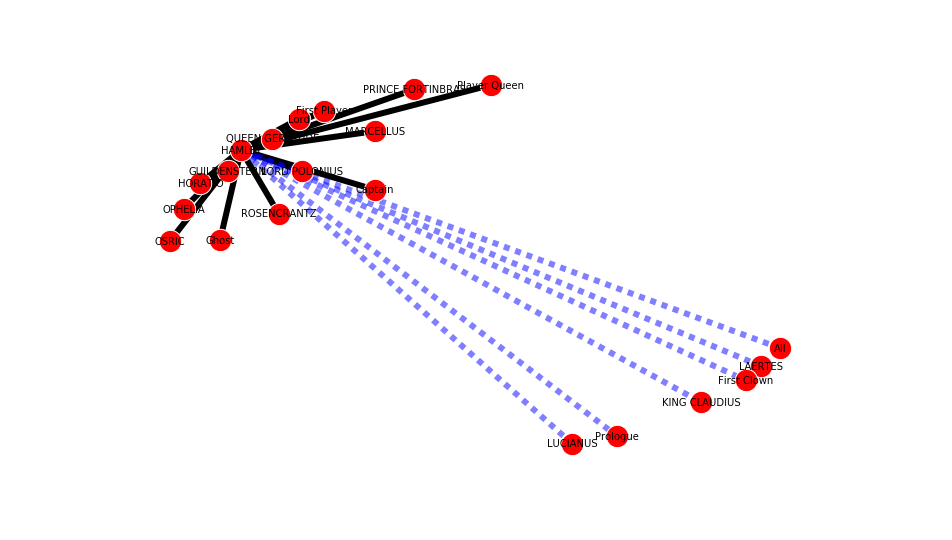

In [38]:
import networkx as nx

G=nx.Graph()

for i, r in df_print.iterrows():
    G.add_edge('HAMLET',r['Speaker'],weight=r['Valence'])


elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >0]
esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <=0]

pos=nx.spring_layout(G) # positions for all nodes

# nodes
nx.draw_networkx_nodes(G,pos,node_size=500)

# edges
nx.draw_networkx_edges(G,pos,edgelist=elarge,
                    width=6)
nx.draw_networkx_edges(G,pos,edgelist=esmall,
                    width=6,alpha=0.5,edge_color='b',style='dashed')

# labels
nx.draw_networkx_labels(G,pos,font_size=10,font_family='sans-serif')

plt.axis('off')
plt.show() # display

In [39]:
print("end")

end
